## Imports

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import spacy
from bertopic import BERTopic
from transformers import pipeline

### Read in the data

In [148]:
df = pd.read_csv('train.csv')

# Word Count

In [206]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [213]:
print(df['word_count'].min())
print(df['word_count'].max())

1
76


In [220]:
# Defining bins and labels for word count

bins = [0, 5, 10, 15, 20, 30, 40, 50, 80, float('inf')]
labels = ['0-5', '6-10', '11-15', '16-20', '21-30', '31-40', '41-50', '51-60', '60+']

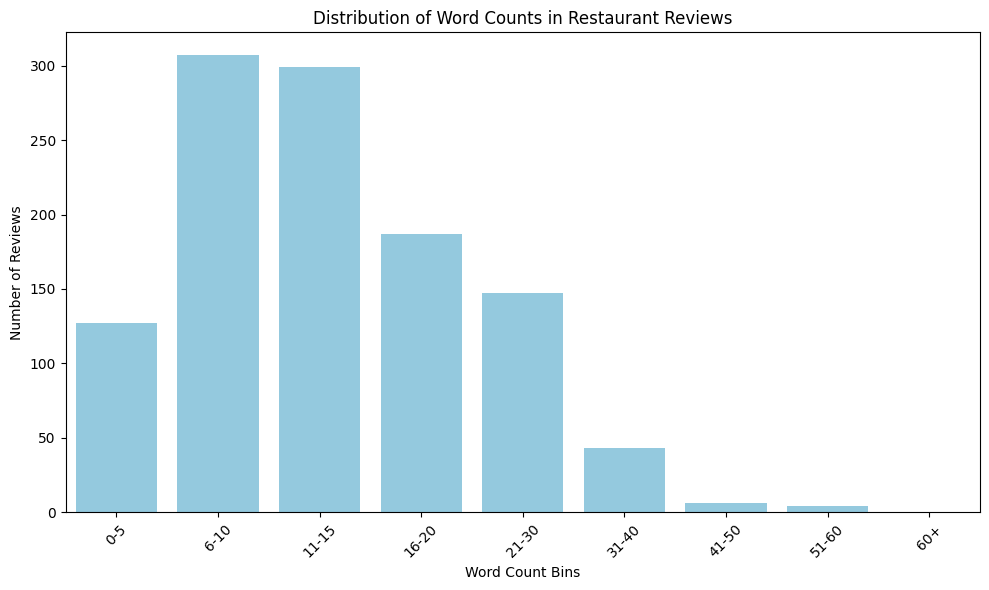

In [223]:
# Bin the data
df['word_count_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels)

# Plotting the dist.
plt.figure(figsize=(10, 6))
sns.countplot(x=df['word_count_bin'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Distribution of Word Counts in Restaurant Reviews')
plt.xlabel('Word Count Bins')
plt.ylabel('Number of Reviews')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Normalized

In [225]:
# Calc. the normalized count (proportion) for each bin
normalized_counts = df['word_count_bin'].value_counts(normalize=True).sort_index()

word_count_bin
0-5      0.113393
6-10     0.274107
11-15    0.266964
16-20    0.166964
21-30    0.131250
31-40    0.038393
41-50    0.005357
51-60    0.003571
60+      0.000000
Name: proportion, dtype: float64

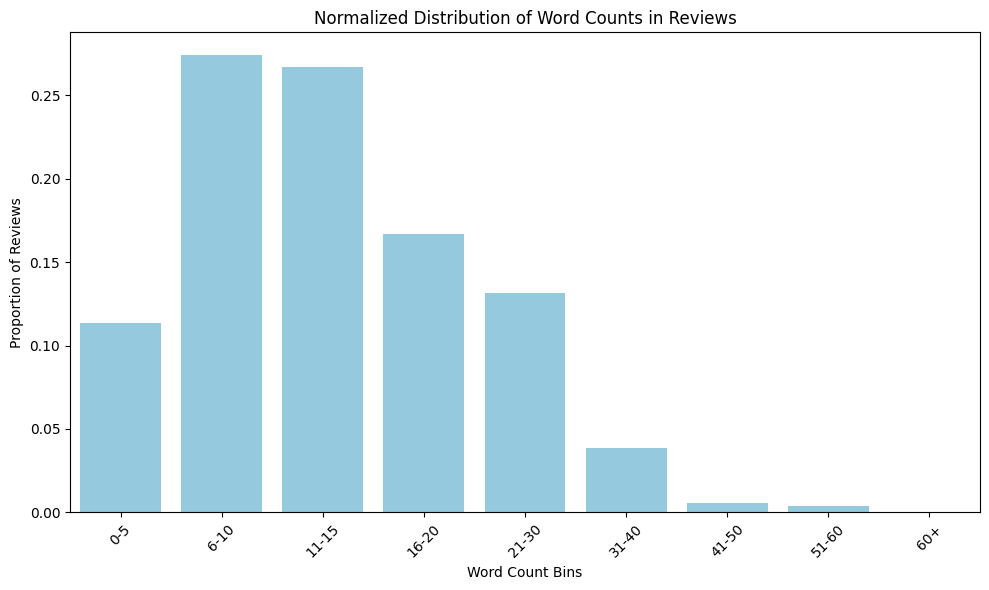

In [226]:
# Plotting the dist.

plt.figure(figsize=(10, 6))
sns.barplot(x=normalized_counts.index, y=normalized_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Normalized Distribution of Word Counts in Reviews')
plt.xlabel('Word Count Bins')
plt.ylabel('Proportion of Reviews')
plt.tight_layout()
plt.show()

# WordCloud representation of relevant phrases (noun chunks)

In [146]:
# Load the lang. model
nlp = spacy.load('en_core_web_lg')

# Convert str reviews to spaCy Doc objects
df['spacy_doc_obj'] = df['text'].apply(lambda x: nlp(x))

# Extract noun chunks from the Doc objects
df['noun_chunks'] = df['spacy_doc_obj'].apply(lambda x: list(x.noun_chunks))

In [142]:
# Function to remove stopwords from chunks to better handle noise and keep only relevant chunks (phrases) for analysis

def process_noun_chunks(chunks):
    phrases = []
    for chunk in chunks:
        # Assuming 'chunk' is a tuple of Token objects
        # Filter out stop words and join the remaining tokens into a phrase
        phrase = ' '.join(token.text for token in chunk if not token.is_stop)
        if phrase:  # Only add non-empty phrases
            phrases.append(phrase)
    return phrases

df['relevant_phrases'] = df['noun_chunks'].apply(process_noun_chunks)

In [143]:
# Extract a final list of relevant phrases (chunks)
agg_phrases = sum(df['relevant_phrases'].tolist(), [])

# Join words in each phrase with an underscore to ensure they are treated as single entities by WordCloud (to compare N-grams of various lengths)
phrases_as_single_tokens = ['_'.join(phrase.split()) for phrase in agg_phrases]

# Join all phrases into a single string (required by WordCloud)
all_phrases = ' '.join(phrases_as_single_tokens)

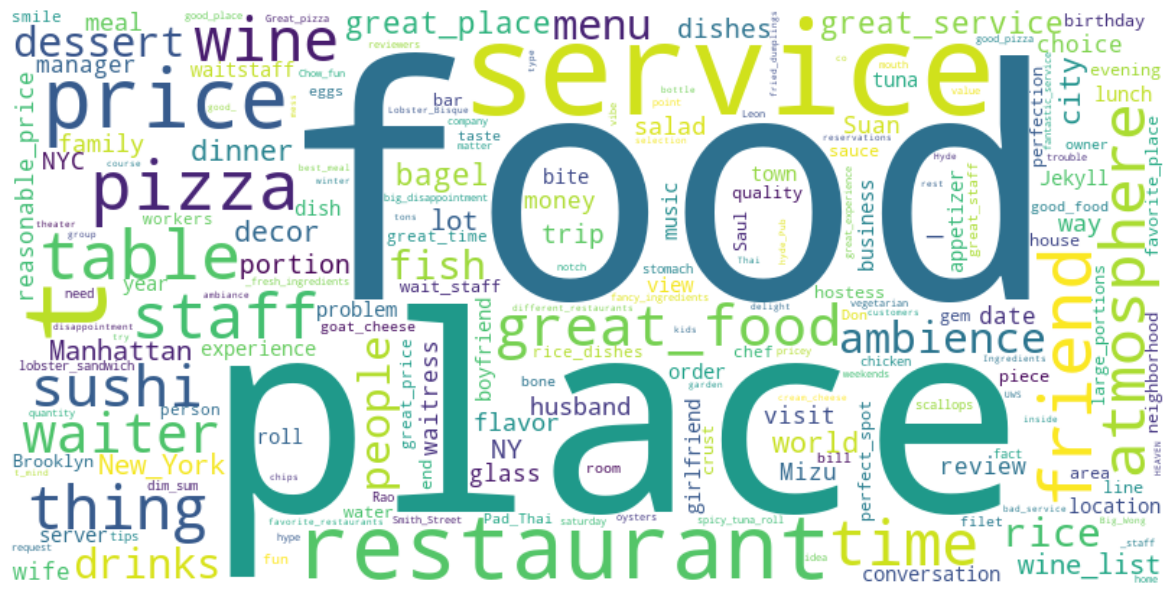

In [144]:
# Display

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_phrases)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# BERTopic

In [151]:
# Concat all reviews into a single list of documents

docs = df['text'].tolist()
len(docs)

1120

In [152]:
# Load spaCy's nlp pipeline excluding irrelevant components to BERTopic

nlp = spacy.load('en_core_web_lg', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

In [153]:
topic_model = BERTopic(embedding_model=nlp)
topics, probs = topic_model.fit_transform(docs)

In [154]:
fig = topic_model.visualize_topics()
fig.show()

# Sentiment Analysis

In [195]:
models = ['cardiffnlp/twitter-roberta-base-sentiment',
          'finiteautomata/bertweet-base-sentiment-analysis',
          'nlptown/bert-base-multilingual-uncased-sentiment']

In [196]:
sentiment_pipeline = pipeline("sentiment-analysis", model=models[0])

In [197]:
df['sentiment'] = df['text'].apply(lambda x: sentiment_pipeline(x))

In [ ]:
LABEL_0 = NEG
LABEL_2 = POS

In [200]:
df['label'] = [item[0]['label'] if item else None for item in df['sentiment']]

In [205]:
round(df['label'].value_counts(dropna=False, normalize=True), 2) * 100

label
LABEL_2    62.0
LABEL_0    20.0
LABEL_1    18.0
Name: proportion, dtype: float64